<a href="https://colab.research.google.com/github/djiraffs/Deep-Learning/blob/main/Week%206/Tugas_Week_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split

# Load JSONL
with open('DeteksiSarkasme.json') as f:
    data = [json.loads(line) for line in f]

# Buat DataFrame
df = pd.DataFrame(data)

# Gunakan kolom yang sesuai
X = df['headline']
y = df['is_sarcastic']

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = max(len(seq) for seq in X_train_seq)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


# Model RNN

Epoch 1: Train Accuracy=0.7122, Test Accuracy=0.8019 | Train Loss=0.5642, Test Loss=0.4248
Epoch 2: Train Accuracy=0.8509, Test Accuracy=0.8398 | Train Loss=0.3616, Test Loss=0.3692
Epoch 3: Train Accuracy=0.8969, Test Accuracy=0.8486 | Train Loss=0.2738, Test Loss=0.3795
Epoch 4: Train Accuracy=0.9201, Test Accuracy=0.8332 | Train Loss=0.2209, Test Loss=0.4379
Epoch 5: Train Accuracy=0.9425, Test Accuracy=0.8435 | Train Loss=0.1602, Test Loss=0.4491
Epoch 6: Train Accuracy=0.9553, Test Accuracy=0.8401 | Train Loss=0.1313, Test Loss=0.5240
Epoch 7: Train Accuracy=0.9699, Test Accuracy=0.8383 | Train Loss=0.0968, Test Loss=0.5879
Epoch 8: Train Accuracy=0.9763, Test Accuracy=0.8407 | Train Loss=0.0807, Test Loss=0.5952
Epoch 9: Train Accuracy=0.9822, Test Accuracy=0.8401 | Train Loss=0.0635, Test Loss=0.6226
Epoch 10: Train Accuracy=0.9854, Test Accuracy=0.8356 | Train Loss=0.0556, Test Loss=0.6236

Final Evaluation on Test Set:
Accuracy : 0.8356
Precision: 0.8050
Recall   : 0.8256
F1 S

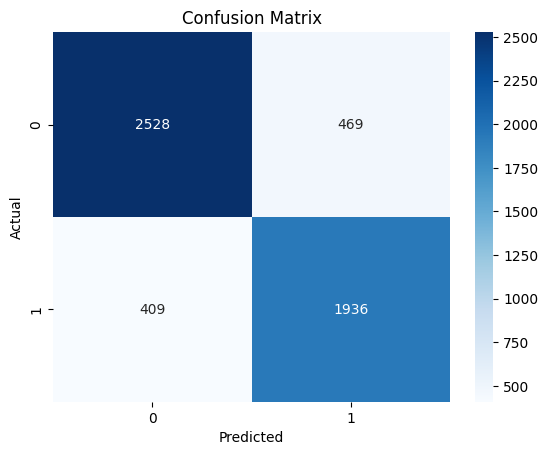

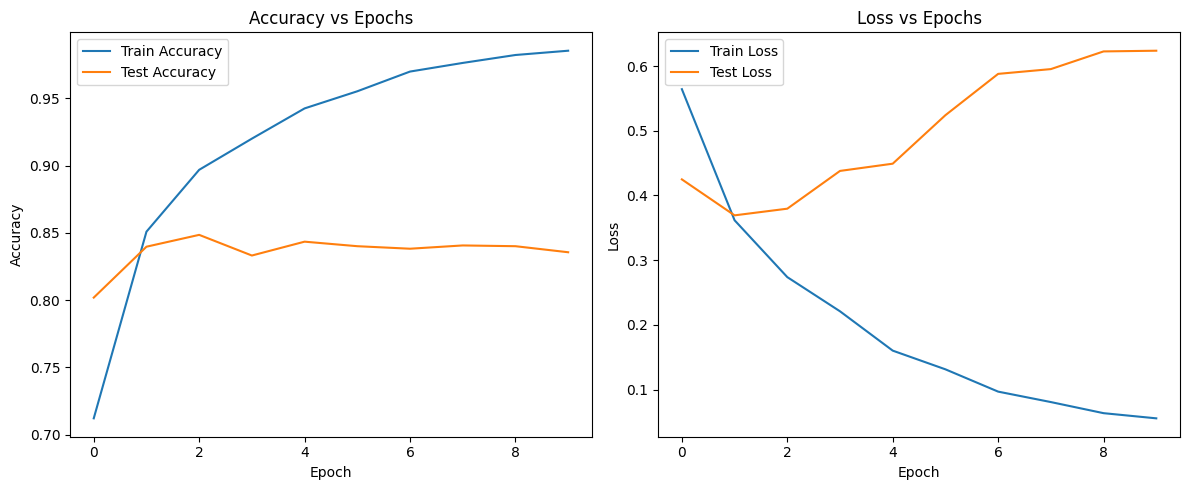

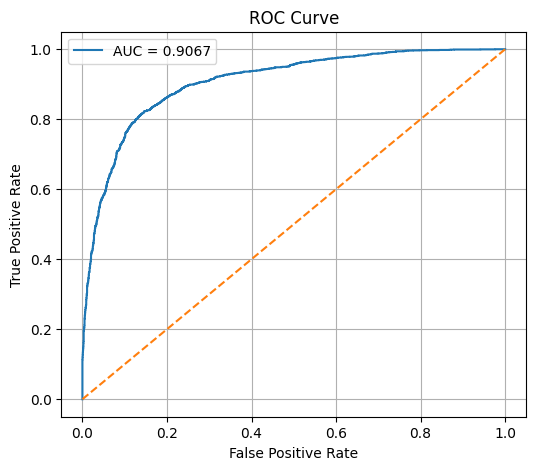


Information:
 1 : Recommended
 0 : Not Recommended



NameError: name 'vocabulary' is not defined

In [30]:
class RNN_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.4):
        super(RNN_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.activation = nn.Sigmoid()

        # Initialize weights for better convergence
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'embedding' in name:
                nn.init.uniform_(param, -0.1, 0.1)
            elif 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, x):
        # x shape: [batch, seq_len]
        embedded = self.embedding(x)  # [batch, seq_len, embed_dim]

        # RNN forward pass
        output, _ = self.rnn(embedded)  # [batch, seq_len, hidden_dim]

        # Global max pooling
        pooled, _ = torch.max(output, dim=1)  # [batch, hidden_dim]

        # Apply dropout before final layer
        pooled = self.dropout(pooled)

        # Final classification layer
        logits = self.fc(pooled).squeeze(1)  # [batch]
        return self.activation(logits)

# Initialize model, loss, and optimizer
model = RNN_Model(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)

# ======= Train & Evaluate =======
train_loss_hist, test_loss_hist = [], []
train_acc_hist, test_acc_hist = [], []

def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs = model(x)
            loss = criterion(probs, y)
            total_loss += loss.item()

            preds = (probs >= 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return total_loss / len(loader), y_true, y_pred, y_prob

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        # Forward pass
        probs = model(x)
        loss = criterion(probs, y)

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        preds = (probs >= 0.5).int()
        correct += (preds == y.int()).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss = total_loss / len(train_loader)
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # Evaluate on test set
    test_loss, y_true, y_pred, y_prob = evaluate(model, test_loader, criterion)
    test_loss_hist.append(test_loss)
    test_acc = accuracy_score(y_true, y_pred)
    test_acc_hist.append(test_acc)

    # Update scheduler based on validation loss
    scheduler.step(test_loss)

    print(f"Epoch {epoch+1}: Train Accuracy={train_acc:.4f}, Test Accuracy={test_acc:.4f} | Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}")

# ======= Metrics =======
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {test_acc_hist[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ======= Visualization =======
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(test_acc_hist, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(test_loss_hist, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")

plt.tight_layout()
plt.show()

# ======= ROC Curve =======
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# ======= Inspect some predictions =======
def get_sample_predictions(model, loader, n_samples=10):
    model.eval()
    samples = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs = model(x)
            preds = (probs >= 0.5).int()

            for i in range(min(n_samples, len(x))):
                # Get the original text
                seq = x[i].cpu().numpy()
                # Convert sequence back to text
                idx_to_word = {idx: word for word, idx in vocabulary.items()}
                words = [idx_to_word.get(idx, '') for idx in seq if idx > 0]
                text = ' '.join(words)

                samples.append({
                    'text': text[:100] + '...',  # First 100 chars
                    'true': y[i].item(),
                    'pred': preds[i].item(),
                    'prob': probs[i].item()
                })

            if len(samples) >= n_samples:
                break

    return samples

print("\nInformation:\n" \
" 1 : Recommended\n" \
" 0 : Not Recommended\n")

samples = get_sample_predictions(model, test_loader)
print("\nSample Predictions:")
for i, sample in enumerate(samples):
    print(f"{i+1}. Text: {sample['text']}")
    print(f"   True: {int(sample['true'])}, Pred: {sample['pred']}, Prob: {sample['prob']:.4f}")
    print()

# Model LSTM

Epoch 1 (PyTorch Ref): Train Accuracy=0.7601, Test Accuracy=0.8426 | Train Loss=0.4663, Test Loss=0.3492
Epoch 2 (PyTorch Ref): Train Accuracy=0.8975, Test Accuracy=0.8538 | Train Loss=0.2541, Test Loss=0.3408
Epoch 3 (PyTorch Ref): Train Accuracy=0.9332, Test Accuracy=0.8532 | Train Loss=0.1830, Test Loss=0.3680
Epoch 4 (PyTorch Ref): Train Accuracy=0.9481, Test Accuracy=0.8414 | Train Loss=0.1488, Test Loss=0.4598
Epoch 5 (PyTorch Ref): Train Accuracy=0.9680, Test Accuracy=0.8422 | Train Loss=0.0976, Test Loss=0.5413
Epoch 6 (PyTorch Ref): Train Accuracy=0.9781, Test Accuracy=0.8413 | Train Loss=0.0720, Test Loss=0.5651
Epoch 7 (PyTorch Ref): Train Accuracy=0.9856, Test Accuracy=0.8368 | Train Loss=0.0506, Test Loss=0.6891
Epoch 8 (PyTorch Ref): Train Accuracy=0.9889, Test Accuracy=0.8371 | Train Loss=0.0392, Test Loss=0.7860
Epoch 9 (PyTorch Ref): Train Accuracy=0.9916, Test Accuracy=0.8371 | Train Loss=0.0306, Test Loss=0.7878
Epoch 10 (PyTorch Ref): Train Accuracy=0.9929, Test Acc

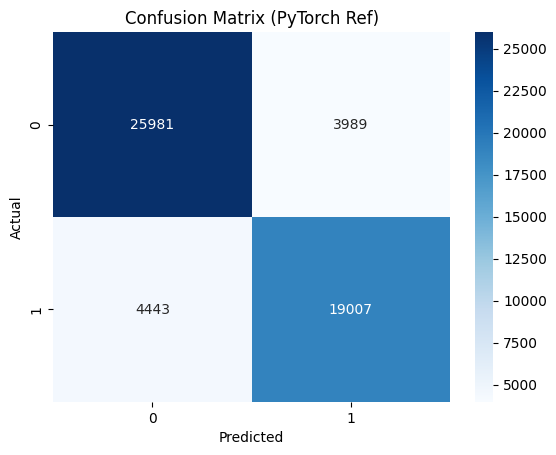

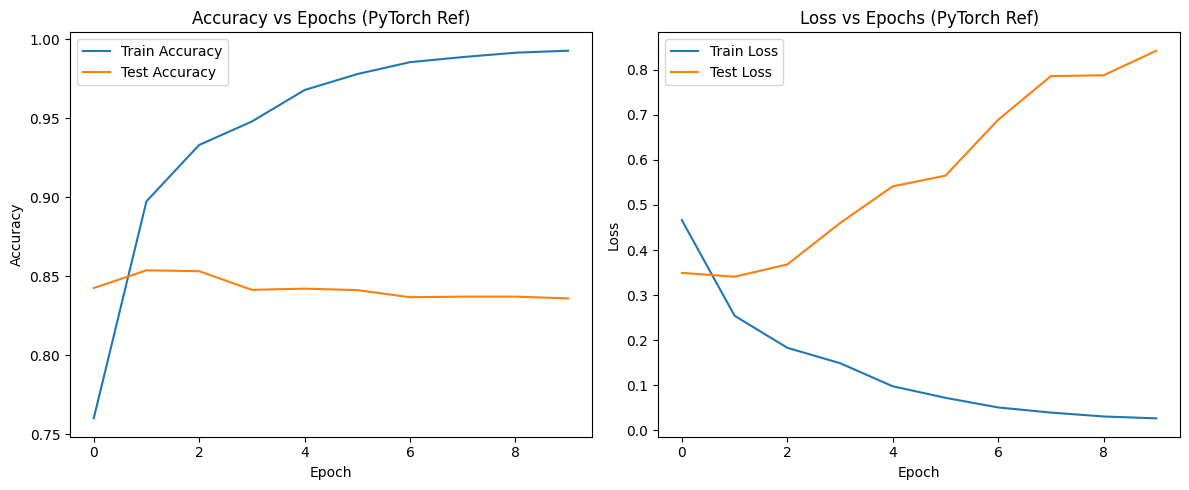

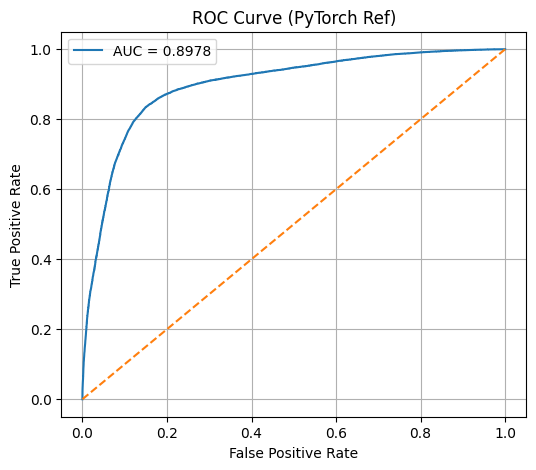


Accuracy vs Epoch (PyTorch Ref)
   epoch  train_accuracy  val_accuracy
0      1        0.760051      0.842568
1      2        0.897505      0.853800
2      3        0.933215      0.853238
3      4        0.948051      0.841445
4      5        0.967988      0.842194
5      6        0.978097      0.841258
6      7        0.985632      0.836765
7      8        0.988861      0.837140
8      9        0.991623      0.837140
9     10        0.992886      0.836016

Loss vs Epoch (PyTorch Ref)
   epoch  train_loss  val_loss
0      1    0.466315  0.349220
1      2    0.254115  0.340794
2      3    0.183049  0.367974
3      4    0.148843  0.459787
4      5    0.097603  0.541322
5      6    0.071976  0.565083
6      7    0.050585  0.689051
7      8    0.039222  0.786018
8      9    0.030550  0.787794
9     10    0.026411  0.842350


In [28]:
# ======================================
# 📦 1. Preprocessing untuk PyTorch
# ======================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asumsi: X_train_pad, y_train, X_test_pad, y_test sudah didefinisikan dan diproses
# Asumsi: vocab_size dan embedding_dim sudah didefinisikan

# Konversi data ke TensorDataset
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDataset(X_train_pad, y_train)
test_dataset = TextDataset(X_test_pad, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

# ======================================
# 🔁 2. Model LSTM PyTorch (Berdasarkan Referensi)
# ======================================
class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.4):
        super(LSTM_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.activation = nn.Sigmoid()

        # Initialize weights for better convergence
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'embedding' in name:
                nn.init.uniform_(param, -0.1, 0.1)
            elif 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, x):
        # x shape: [batch, seq_len]
        embedded = self.embedding(x)  # [batch, seq_len, embed_dim]

        # LSTM forward pass
        output, _ = self.lstm(embedded)  # [batch, seq_len, hidden_dim]

        # Global max pooling
        pooled, _ = torch.max(output, dim=1)  # [batch, hidden_dim]

        # Apply dropout before final layer
        pooled = self.dropout(pooled)

        # Final classification layer
        logits = self.fc(pooled).squeeze(1)  # [batch]
        return self.activation(logits)

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = 10000  # Sesuaikan dengan ukuran vocabulary Anda
embedding_dim = 128
hidden_dim = 256
num_layers = 2
dropout_prob = 0.4
model_pt = LSTM_Model(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob).to(device)
criterion_pt = nn.BCELoss()
optimizer_pt = optim.Adam(model_pt.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_pt = optim.lr_scheduler.ReduceLROnPlateau(optimizer_pt, 'min', patience=1, factor=0.5)

# ======= Evaluate Function =======
def evaluate(model, loader, criterion):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs = model(x)
            loss = criterion(probs, y)
            total_loss += loss.item()

            preds = (probs >= 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return total_loss / len(loader), y_true, y_pred, y_prob

# ======= Train & Evaluate =======
epochs = 10
train_loss_hist_pt, test_loss_hist_pt = [], []
train_acc_hist_pt, test_acc_hist_pt = [], []
all_y_true_pt, all_y_pred_pt, all_y_prob_pt = [], [], []

for epoch in range(epochs):
    model_pt.train()
    total_loss = 0
    correct = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer_pt.zero_grad()

        # Forward pass
        probs = model_pt(x)
        loss = criterion_pt(probs, y)

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model_pt.parameters(), max_norm=1.0)

        optimizer_pt.step()

        total_loss += loss.item()
        preds = (probs >= 0.5).int()
        correct += (preds == y.int()).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss = total_loss / len(train_loader)
    train_loss_hist_pt.append(train_loss)
    train_acc_hist_pt.append(train_acc)

    # Evaluate on test set
    test_loss, y_true, y_pred, y_prob = evaluate(model_pt, test_loader, criterion_pt)
    test_loss_hist_pt.append(test_loss)
    test_acc = accuracy_score(y_true, y_pred)
    test_acc_hist_pt.append(test_acc)
    all_y_true_pt.extend(y_true)
    all_y_pred_pt.extend(y_pred)
    all_y_prob_pt.extend(y_prob)

    # Update scheduler based on validation loss
    scheduler_pt.step(test_loss)

    print(f"Epoch {epoch+1} (PyTorch Ref): Train Accuracy={train_acc:.4f}, Test Accuracy={test_acc:.4f} | Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}")

# ======= Metrics =======
precision_pt = precision_score(all_y_true_pt, all_y_pred_pt)
recall_pt = recall_score(all_y_true_pt, all_y_pred_pt)
f1_pt = f1_score(all_y_true_pt, all_y_pred_pt)
auc_pt = roc_auc_score(all_y_true_pt, all_y_prob_pt)
fpr_pt, tpr_pt, _ = roc_curve(all_y_true_pt, all_y_prob_pt)

print(f"\nFinal Evaluation on Test Set (PyTorch Ref):")
print(f"Accuracy : {test_acc_hist_pt[-1]:.4f}")
print(f"Precision: {precision_pt:.4f}")
print(f"Recall   : {recall_pt:.4f}")
print(f"F1 Score : {f1_pt:.4f}")
print(f"AUC      : {auc_pt:.4f}")

# Confusion Matrix
cm_pt = confusion_matrix(all_y_true_pt, all_y_pred_pt)
sns.heatmap(cm_pt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (PyTorch Ref)')
plt.show()

# ======= Visualization =======
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_hist_pt, label="Train Accuracy")
plt.plot(test_acc_hist_pt, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs (PyTorch Ref)")

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist_pt, label="Train Loss")
plt.plot(test_loss_hist_pt, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs (PyTorch Ref)")

plt.tight_layout()
plt.show()

# ======= ROC Curve =======
plt.figure(figsize=(6, 5))
plt.plot(fpr_pt, tpr_pt, label=f"AUC = {auc_pt:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (PyTorch Ref)")
plt.legend()
plt.grid(True)
plt.show()

# ======= Accuracy & Loss Table =======
history_df_pt_ref = pd.DataFrame({
    "epoch": list(range(1, epochs + 1)),
    "train_accuracy": train_acc_hist_pt,
    "val_accuracy": test_acc_hist_pt,
    "train_loss": train_loss_hist_pt,
    "val_loss": test_loss_hist_pt
})
print("\nAccuracy vs Epoch (PyTorch Ref)")
print(history_df_pt_ref[["epoch", "train_accuracy", "val_accuracy"]])

print("\nLoss vs Epoch (PyTorch Ref)")
print(history_df_pt_ref[["epoch", "train_loss", "val_loss"]])

# Model GRU

Epoch 1 (GRU Ref): Train Accuracy=0.7858, Test Accuracy=0.8443 | Train Loss=0.4524, Test Loss=0.3489
Epoch 2 (GRU Ref): Train Accuracy=0.9040, Test Accuracy=0.8474 | Train Loss=0.2428, Test Loss=0.3591
Epoch 3 (GRU Ref): Train Accuracy=0.9328, Test Accuracy=0.8456 | Train Loss=0.1747, Test Loss=0.4043
Epoch 4 (GRU Ref): Train Accuracy=0.9623, Test Accuracy=0.8401 | Train Loss=0.1052, Test Loss=0.4694
Epoch 5 (GRU Ref): Train Accuracy=0.9757, Test Accuracy=0.8401 | Train Loss=0.0713, Test Loss=0.6223
Epoch 6 (GRU Ref): Train Accuracy=0.9838, Test Accuracy=0.8338 | Train Loss=0.0457, Test Loss=0.7455
Epoch 7 (GRU Ref): Train Accuracy=0.9875, Test Accuracy=0.8340 | Train Loss=0.0341, Test Loss=0.8642
Epoch 8 (GRU Ref): Train Accuracy=0.9903, Test Accuracy=0.8338 | Train Loss=0.0263, Test Loss=0.9068
Epoch 9 (GRU Ref): Train Accuracy=0.9914, Test Accuracy=0.8334 | Train Loss=0.0224, Test Loss=0.9355
Epoch 10 (GRU Ref): Train Accuracy=0.9927, Test Accuracy=0.8336 | Train Loss=0.0205, Test L

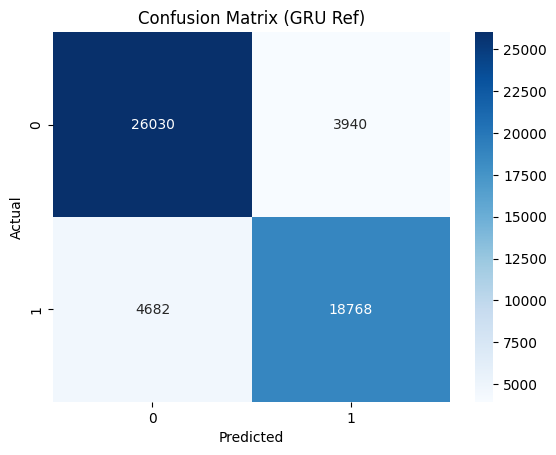

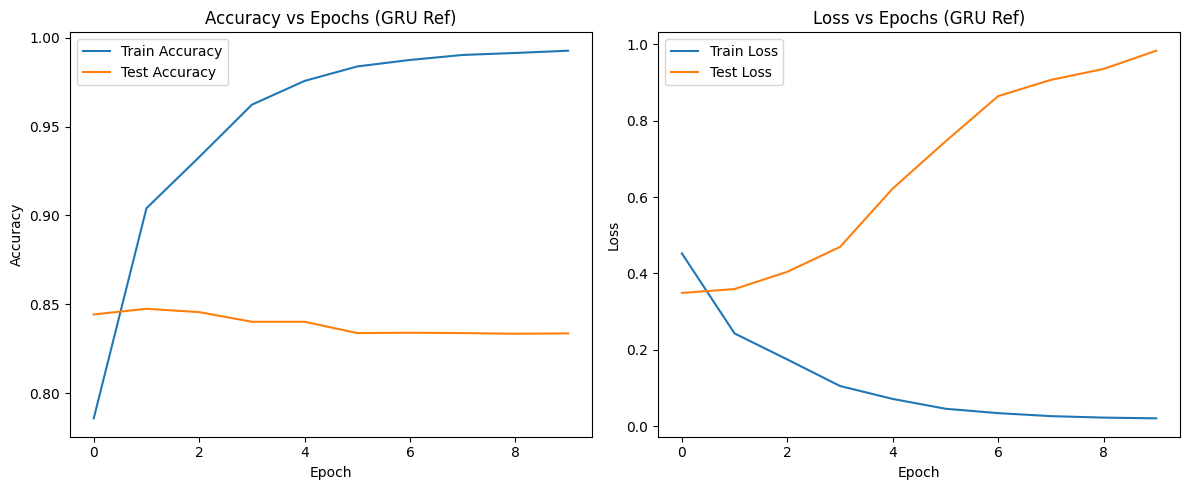

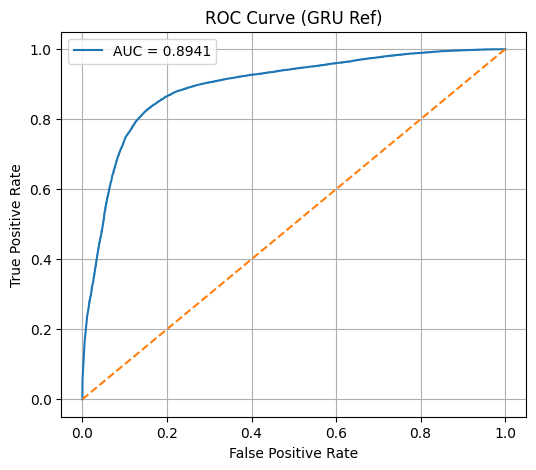


Accuracy vs Epoch (GRU Ref)
   epoch  train_accuracy  val_accuracy
0      1        0.785791      0.844253
1      2        0.904011      0.847435
2      3        0.932794      0.845563
3      4        0.962278      0.840135
4      5        0.975663      0.840135
5      6        0.983807      0.833770
6      7        0.987457      0.833957
7      8        0.990265      0.833770
8      9        0.991389      0.833396
9     10        0.992652      0.833583

Loss vs Epoch (GRU Ref)
   epoch  train_loss  val_loss
0      1    0.452416  0.348941
1      2    0.242786  0.359127
2      3    0.174731  0.404298
3      4    0.105201  0.469364
4      5    0.071316  0.622286
5      6    0.045678  0.745543
6      7    0.034125  0.864248
7      8    0.026336  0.906801
8      9    0.022444  0.935465
9     10    0.020524  0.983199


In [29]:
# ======================================
# 📦 1. Preprocessing untuk PyTorch
# ======================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asumsi: X_train_pad, y_train, X_test_pad, y_test sudah didefinisikan dan diproses
# Asumsi: vocab_size dan embedding_dim sudah didefinisikan

# Konversi data ke TensorDataset
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDataset(X_train_pad, y_train)
test_dataset = TextDataset(X_test_pad, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

# ======================================
# 🔁 2. Model GRU PyTorch (Berdasarkan Referensi)
# ======================================
class GRU_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.4):
        super(GRU_Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.activation = nn.Sigmoid()

        # Initialize weights for better convergence
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'embedding' in name:
                nn.init.uniform_(param, -0.1, 0.1)
            elif 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

    def forward(self, x):
        # x shape: [batch, seq_len]
        embedded = self.embedding(x)  # [batch, seq_len, embed_dim]

        # GRU forward pass
        output, _ = self.gru(embedded)  # [batch, seq_len, hidden_dim]

        # Global max pooling
        pooled, _ = torch.max(output, dim=1)  # [batch, hidden_dim]

        # Apply dropout before final layer
        pooled = self.dropout(pooled)

        # Final classification layer
        logits = self.fc(pooled).squeeze(1)  # [batch]
        return self.activation(logits)

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = 10000  # Sesuaikan dengan ukuran vocabulary Anda
embedding_dim = 128
hidden_dim = 256
num_layers = 2
dropout_prob = 0.4
model_gru = GRU_Model(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob).to(device)
criterion_gru = nn.BCELoss()
optimizer_gru = optim.Adam(model_gru.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_gru = optim.lr_scheduler.ReduceLROnPlateau(optimizer_gru, 'min', patience=1, factor=0.5)

# ======= Evaluate Function =======
def evaluate_gru(model, loader, criterion):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            probs = model(x)
            loss = criterion(probs, y)
            total_loss += loss.item()

            preds = (probs >= 0.5).int()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return total_loss / len(loader), y_true, y_pred, y_prob

# ======= Train & Evaluate =======
epochs = 10
train_loss_hist_gru, test_loss_hist_gru = [], []
train_acc_hist_gru, test_acc_hist_gru = [], []
all_y_true_gru, all_y_pred_gru, all_y_prob_gru = [], [], []

for epoch in range(epochs):
    model_gru.train()
    total_loss = 0
    correct = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer_gru.zero_grad()

        # Forward pass
        probs = model_gru(x)
        loss = criterion_gru(probs, y)

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model_gru.parameters(), max_norm=1.0)

        optimizer_gru.step()

        total_loss += loss.item()
        preds = (probs >= 0.5).int()
        correct += (preds == y.int()).sum().item()

    train_acc = correct / len(train_dataset)
    train_loss = total_loss / len(train_loader)
    train_loss_hist_gru.append(train_loss)
    train_acc_hist_gru.append(train_acc)

    # Evaluate on test set
    test_loss, y_true, y_pred, y_prob = evaluate_gru(model_gru, test_loader, criterion_gru)
    test_loss_hist_gru.append(test_loss)
    test_acc = accuracy_score(y_true, y_pred)
    test_acc_hist_gru.append(test_acc)
    all_y_true_gru.extend(y_true)
    all_y_pred_gru.extend(y_pred)
    all_y_prob_gru.extend(y_prob)

    # Update scheduler based on validation loss
    scheduler_gru.step(test_loss)

    print(f"Epoch {epoch+1} (GRU Ref): Train Accuracy={train_acc:.4f}, Test Accuracy={test_acc:.4f} | Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}")

# ======= Metrics =======
precision_gru = precision_score(all_y_true_gru, all_y_pred_gru)
recall_gru = recall_score(all_y_true_gru, all_y_pred_gru)
f1_gru = f1_score(all_y_true_gru, all_y_pred_gru)
auc_gru = roc_auc_score(all_y_true_gru, all_y_prob_gru)
fpr_gru, tpr_gru, _ = roc_curve(all_y_true_gru, all_y_prob_gru)

print(f"\nFinal Evaluation on Test Set (GRU Ref):")
print(f"Accuracy : {test_acc_hist_gru[-1]:.4f}")
print(f"Precision: {precision_gru:.4f}")
print(f"Recall   : {recall_gru:.4f}")
print(f"F1 Score : {f1_gru:.4f}")
print(f"AUC      : {auc_gru:.4f}")

# Confusion Matrix
cm_gru = confusion_matrix(all_y_true_gru, all_y_pred_gru)
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (GRU Ref)')
plt.show()

# ======= Visualization =======
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc_hist_gru, label="Train Accuracy")
plt.plot(test_acc_hist_gru, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs (GRU Ref)")

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist_gru, label="Train Loss")
plt.plot(test_loss_hist_gru, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs (GRU Ref)")

plt.tight_layout()
plt.show()

# ======= ROC Curve =======
plt.figure(figsize=(6, 5))
plt.plot(fpr_gru, tpr_gru, label=f"AUC = {auc_gru:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (GRU Ref)")
plt.legend()
plt.grid(True)
plt.show()

# ======= Accuracy & Loss Table =======
history_df_gru_ref = pd.DataFrame({
    "epoch": list(range(1, epochs + 1)),
    "train_accuracy": train_acc_hist_gru,
    "val_accuracy": test_acc_hist_gru,
    "train_loss": train_loss_hist_gru,
    "val_loss": test_loss_hist_gru
})
print("\nAccuracy vs Epoch (GRU Ref)")
print(history_df_gru_ref[["epoch", "train_accuracy", "val_accuracy"]])

print("\nLoss vs Epoch (GRU Ref)")
print(history_df_gru_ref[["epoch", "train_loss", "val_loss"]])